In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("input/cell_images/cell_images"))
from glob import glob
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import fnmatch
import keras
from time import sleep
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k

['Parasitized', 'Uninfected']


Using TensorFlow backend.


In [2]:
imagePatches_0 = glob('input/cell_images/cell_images/Uninfected/*.png', recursive=True)
imagePatches_1 = glob('input/cell_images/cell_images/Parasitized/*.png', recursive=True)
print(len(imagePatches_0))
print(len(imagePatches_1))

13779
13779


In [3]:
x=[]
y=[]
for img in imagePatches_0:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    y.append(0)
for img in imagePatches_1:
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (224, 224), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    y.append(1)
x = np.array(x)
y = np.array(y)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)
del x, y

In [5]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
model = Sequential()
model.add(Conv2D(32,(7,7),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(GlobalAveragePooling2D())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [6]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='model_check_path.hdf5',monitor="val_acc", save_best_only=True, save_weights_only=False)
hist = model.fit(x_train,y_train,batch_size = 32, epochs = 10, verbose=1,  validation_split=0.2, callbacks=[mcp])

Train on 17636 samples, validate on 4410 samples
Epoch 1/10
17636/17636 [==============================] - 4951s 281ms/step - loss: 0.3087 - acc: 0.8649 - val_loss: 0.1879 - val_acc: 0.9268
Epoch 2/10
17636/17636 [==============================] - 4835s 274ms/step - loss: 0.1866 - acc: 0.9335 - val_loss: 0.1667 - val_acc: 0.9401
Epoch 3/10
17636/17636 [==============================] - 4817s 273ms/step - loss: 0.1694 - acc: 0.9419 - val_loss: 0.1449 - val_acc: 0.9492
Epoch 4/10
17636/17636 [==============================] - 4800s 272ms/step - loss: 0.1516 - acc: 0.9470 - val_loss: 0.1383 - val_acc: 0.9558
Epoch 5/10
17636/17636 [==============================] - 4773s 271ms/step - loss: 0.1451 - acc: 0.9502 - val_loss: 0.1267 - val_acc: 0.9608
Epoch 6/10
17636/17636 [==============================] - 4855s 275ms/step - loss: 0.1374 - acc: 0.9525 - val_loss: 0.1262 - val_acc: 0.9565
Epoch 7/10
17636/17636 [==============================] - 4775s 271ms/step - loss: 0.1276 - acc: 0.9559 -

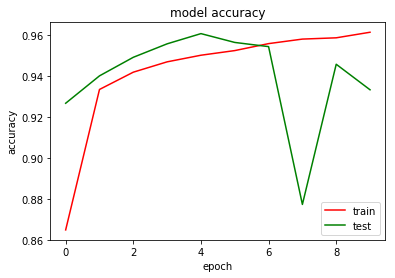

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

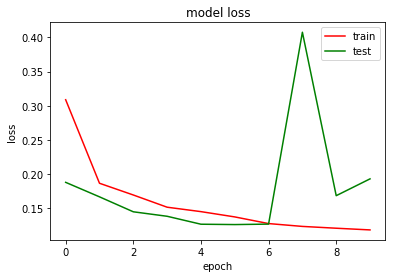

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
model.load_weights('model_check_path.hdf5')

In [12]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2791
           1       0.97      0.95      0.96      2721

   micro avg       0.96      0.96      0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

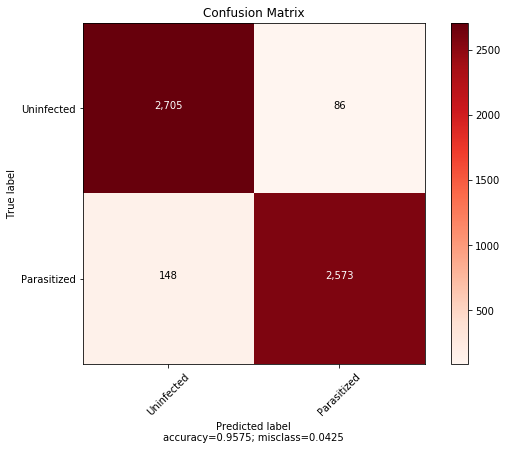

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['Uninfected', 'Parasitized'],
                      title        = "Confusion Matrix")